In [ ]:
%reload_ext autoreload
%autoreload 2

# 1. Load peptdeep models

In [ ]:
import os
import wget
if not os.path.exists('sandbox/test_files'):
    os.makedirs('sandbox/test_files')
def download_data(url, file_path):
    if not os.path.exists(file_path):
        wget.download(url, file_path)

from peptdeep.model.rt import (
    evaluate_linear_regression, evaluate_linear_regression_plot
)

from peptdeep.pretrained_models import ModelManager

models = ModelManager()
models.load_installed_models()

In [ ]:
ms2_model = models.ms2_model
ms2_model.get_parameter_num()

3988974

In [ ]:
rt_model = models.rt_model
rt_model.get_parameter_num()

708224

In [ ]:
ccs_model = models.ccs_model
ccs_model.get_parameter_num()

713452

# 2. Test ccs_model

In [ ]:
from alphabase.io.psm_reader import psm_reader_provider
ccs_url = 'https://datashare.biochem.mpg.de/s/uTGa7PliZzRJU4g/download'
ccs = 'sandbox/test_files/PXD019086_Celegant_evidence.txt'
download_data(ccs_url, ccs)
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.load(ccs)

/Users/zengwenfeng/Workspace/AlphaBase/alphabase/io/psm_reader/psm_reader.py:182: DtypeWarning: Columns (61) have mixed types.Specify dtype option on import or set low_memory=False.
  origin_df = self._load_file(_file)


## CCS prediction is very good

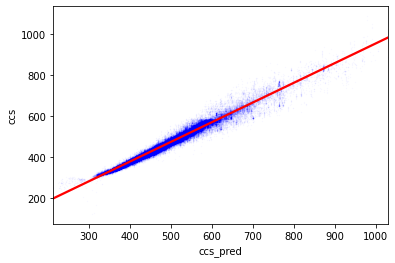

,R_square,R,slope,intercept,n_sample
0,0.97,0.984886,0.9591,-4.9418,141263.0


In [ ]:
psm_df = mq_reader.psm_df#.groupby(['sequence','mods','mod_sites','nAA','charge'])['ccs'].median().reset_index()
predict_df = ccs_model.predict(psm_df)
evaluate_linear_regression_plot(predict_df, x='ccs_pred',y='ccs')
evaluate_linear_regression(predict_df, x='ccs_pred',y='ccs')

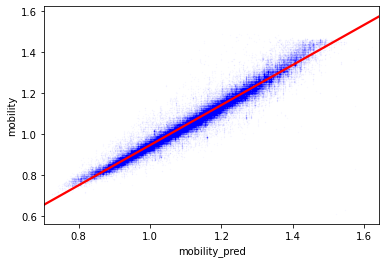

,R_square,R,slope,intercept,n_sample
0,0.958,0.978775,0.9782,-0.0327,141263.0


In [ ]:
predict_df = ccs_model.ccs_to_mobility_pred(predict_df)
evaluate_linear_regression_plot(predict_df, x='mobility_pred',y='mobility')
evaluate_linear_regression(predict_df, x='mobility_pred',y='mobility')

## Transfer learning on CCS does not provide much help

[Training] Epoch=1, Mean Loss=27.67469824814215
[Training] Epoch=2, Mean Loss=22.42431716221135
[Training] Epoch=3, Mean Loss=20.50607077668353
[Training] Epoch=4, Mean Loss=18.997461470161998
[Training] Epoch=5, Mean Loss=18.613189371620738
[Training] Epoch=6, Mean Loss=17.423454633573208
[Training] Epoch=7, Mean Loss=18.01963351412517
[Training] Epoch=8, Mean Loss=16.40191063066808
[Training] Epoch=9, Mean Loss=16.620624960922612
[Training] Epoch=10, Mean Loss=15.119410921887654
[Training] Epoch=11, Mean Loss=16.107560832326005
[Training] Epoch=12, Mean Loss=15.534236803287413
[Training] Epoch=13, Mean Loss=15.745832722361495
[Training] Epoch=14, Mean Loss=16.908481516489168
[Training] Epoch=15, Mean Loss=15.588562639748178
[Training] Epoch=16, Mean Loss=14.984564222940584
[Training] Epoch=17, Mean Loss=15.009391261310112
[Training] Epoch=18, Mean Loss=15.496347997246719
[Training] Epoch=19, Mean Loss=14.103635252975836
[Training] Epoch=20, Mean Loss=12.638847769760504


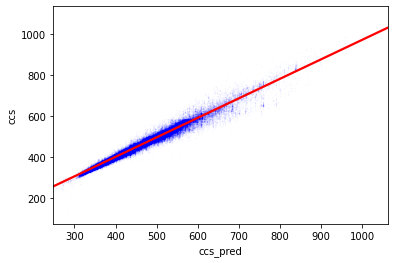

,R_square,R,slope,intercept,n_sample
0,0.971,0.985393,0.9502,21.6847,138204.0


In [ ]:
import numpy as np
import pandas as pd
n_train = 5000

from peptdeep.model.rt import uniform_sampling
train_df, test_df = uniform_sampling(psm_df, target='ccs', n_train=n_train, return_test_df=True)
ccs_model.train(train_df, verbose=True)
predict_df = ccs_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='ccs_pred',y='ccs')
evaluate_linear_regression(predict_df, x='ccs_pred',y='ccs')

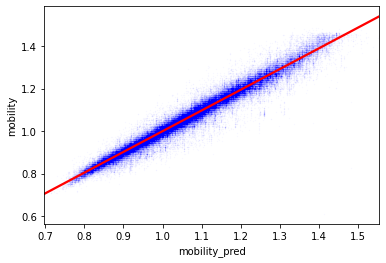

,R_square,R,slope,intercept,n_sample
0,0.96,0.979796,0.976,0.0237,138204.0


In [ ]:
predict_df = ccs_model.ccs_to_mobility_pred(predict_df)
evaluate_linear_regression_plot(predict_df, x='mobility_pred',y='mobility')
evaluate_linear_regression(predict_df, x='mobility_pred',y='mobility')

<AxesSubplot:ylabel='Frequency'>

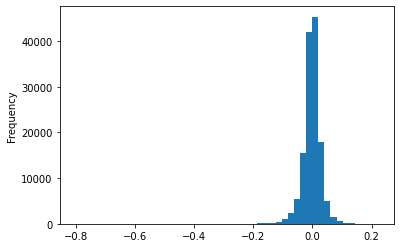

In [ ]:
(predict_df.mobility-predict_df.mobility_pred).plot.hist(bins=50)

# 3. Test rt_model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def adjust_rt_pred(train_df, test_df, x='rt_pred', y='rt_norm', target='rt_adjust'):
    model = KNeighborsRegressor(n_neighbors=3, weights='distance')
    model.fit(train_df[x].values.reshape((-1,1)), train_df[y].values.reshape((-1,1)))
    test_df[target] = model.predict(test_df[x].values.reshape((-1,1)))
    return test_df

## Test on Pan-human library

In [ ]:
from alphabase.io.psm_reader import psm_reader_provider

phl_url = 'https://datashare.biochem.mpg.de/s/GyVnHxasODv5hYc/download'
phl = 'sandbox/test_files/phl004_canonical_s32_osw.tsv'
download_data(phl_url, phl)

mq_reader = psm_reader_provider.get_reader('openswath')
mq_reader.load(phl)

mq_reader = psm_reader_provider.get_reader('openswath')
mq_reader.load(phl)

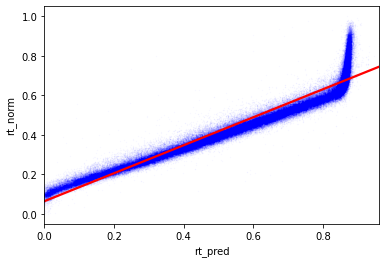

,R_square,R,slope,intercept,n_sample
0,0.924,0.961249,0.7075,0.065,204564.0


In [ ]:
psm_df = mq_reader.psm_df#.groupby(['sequence','mods','mod_sites','nAA'])['rt_norm'].median().reset_index()
predict_df = rt_model.predict(psm_df)

evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

## Test for KNN-based RT calibration on phl

Better but not very good. It is useful when we only have detected RT values without peptide information.

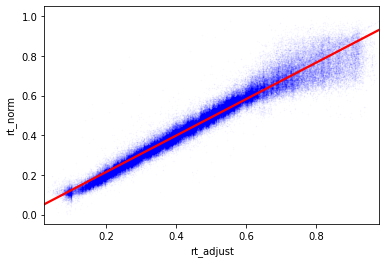

,R_square,R,slope,intercept,n_sample
0,0.954,0.976729,0.92,0.0312,199564.0


In [ ]:
import numpy as np
import pandas as pd
n_train = 5000

from peptdeep.model.rt import uniform_sampling
train_df, test_df = uniform_sampling(
    psm_df, target='rt_norm', n_train=n_train, return_test_df=True
)
predict_df = adjust_rt_pred(train_df, test_df)
evaluate_linear_regression_plot(predict_df, x='rt_adjust',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_adjust',y='rt_norm')

## Transfer learning on phl

In [ ]:
rt_model.train(train_df, epoch=20, verbose=True, verbose_each_epoch=False)

[Training] Epoch=1, Mean Loss=0.04316662267471353
[Training] Epoch=2, Mean Loss=0.03180241996111969
[Training] Epoch=3, Mean Loss=0.02344859668907399
[Training] Epoch=4, Mean Loss=0.020412476054237533
[Training] Epoch=5, Mean Loss=0.022304239954488974
[Training] Epoch=6, Mean Loss=0.017174581395617377
[Training] Epoch=7, Mean Loss=0.01700133458750012
[Training] Epoch=8, Mean Loss=0.019484098496225972
[Training] Epoch=9, Mean Loss=0.017604698572540656
[Training] Epoch=10, Mean Loss=0.015739520720671862
[Training] Epoch=11, Mean Loss=0.014358153430900225
[Training] Epoch=12, Mean Loss=0.01701598151703365
[Training] Epoch=13, Mean Loss=0.01492659382832547
[Training] Epoch=14, Mean Loss=0.01645984864444472
[Training] Epoch=15, Mean Loss=0.015095364292695498
[Training] Epoch=16, Mean Loss=0.017223474724839132
[Training] Epoch=17, Mean Loss=0.014123942285853749
[Training] Epoch=18, Mean Loss=0.015786654587524634
[Training] Epoch=19, Mean Loss=0.014934128208551556
[Training] Epoch=20, Mean Lo

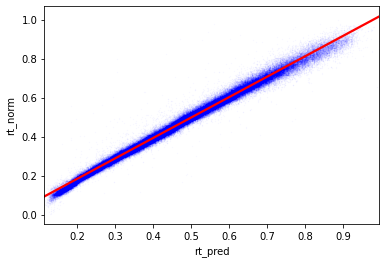

,R_square,R,slope,intercept,n_sample
0,0.989,0.994485,1.0476,-0.0262,199564.0


In [ ]:
predict_df = rt_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

## Test on non-linear gradient data

In [ ]:
from peptdeep.pretrained_models import ModelManager

models = ModelManager()
models.load_installed_models()
rt_model = models.rt_model

nonlinear_url = 'https://datashare.biochem.mpg.de/s/HAjrz1ONA4vxCJL/download'
nonlinear = 'sandbox/test_files/PXD023848_nonlinear_gradient_evidence.txt'
download_data(nonlinear_url, nonlinear)

In [ ]:
from alphabase.io.psm_reader import psm_reader_provider

mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.load(nonlinear)

d:\workspace\peptdeep\peptdeep\psm_reader\psm_reader.py:168: DtypeWarning: Columns (52) have mixed types.Specify dtype option on import or set low_memory=False.
  origin_df = self._load_file(filename)


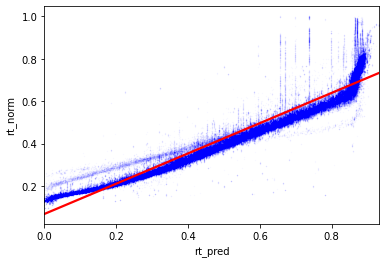

,R_square,R,slope,intercept,n_sample
0,0.925,0.961769,0.7131,0.0688,254801.0


In [ ]:
psm_df = mq_reader.psm_df#.groupby(['sequence','mods','mod_sites','nAA'])['rt_norm'].median().reset_index()
for _, df_group in psm_df.groupby('raw_name'):
    psm_df.loc[df_group.index,'rt_norm'] = df_group.rt_norm / df_group.rt_norm.max()

predict_df = rt_model.predict(psm_df)

evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

## Transfer learning for non-linear data

In [ ]:
import numpy as np
import pandas as pd
n_train = 5000

from peptdeep.model.rt import uniform_sampling
train_df, test_df = uniform_sampling(psm_df, target='rt_norm', n_train=n_train, return_test_df=True)
rt_model.train(train_df, epoch=20, verbose=True, verbose_each_epoch=False)

[Training] Epoch=1, Mean Loss=0.05443316282561192
[Training] Epoch=2, Mean Loss=0.03514740019081495
[Training] Epoch=3, Mean Loss=0.028012990629157193
[Training] Epoch=4, Mean Loss=0.026608508319044724
[Training] Epoch=5, Mean Loss=0.025335390526705828
[Training] Epoch=6, Mean Loss=0.02151295244216155
[Training] Epoch=7, Mean Loss=0.02284555258945777
[Training] Epoch=8, Mean Loss=0.02214340540843132
[Training] Epoch=9, Mean Loss=0.020879356154742148
[Training] Epoch=10, Mean Loss=0.018959273799107626
[Training] Epoch=11, Mean Loss=0.017146874756480638
[Training] Epoch=12, Mean Loss=0.016659948509186506
[Training] Epoch=13, Mean Loss=0.016957040494069073
[Training] Epoch=14, Mean Loss=0.021886939744059093
[Training] Epoch=15, Mean Loss=0.01964927536363785
[Training] Epoch=16, Mean Loss=0.01754980779085786
[Training] Epoch=17, Mean Loss=0.01789762466572798
[Training] Epoch=18, Mean Loss=0.01598154514645919
[Training] Epoch=19, Mean Loss=0.014918726451026324
[Training] Epoch=20, Mean Loss

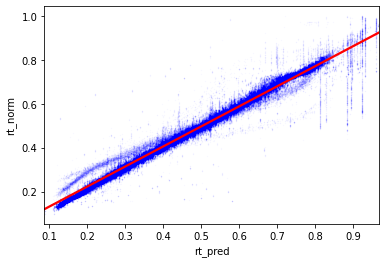

,R_square,R,slope,intercept,n_sample
0,0.973,0.986408,0.9159,0.0393,250291.0


In [ ]:
predict_df = rt_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

<AxesSubplot:ylabel='Frequency'>

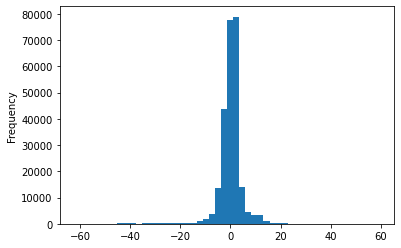

In [ ]:
(predict_df.rt.max()*(predict_df.rt_norm-predict_df.rt_pred)).plot.hist(bins=50)

### There is an outlier raw file, resulting in some outlier predictions

In [ ]:
for raw_name, group_df in psm_df.groupby('raw_name'):
    print(raw_name, 'gradient =', group_df.rt.max())

B07857_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-1 gradient = 138.8
B07859_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-2 gradient = 82.357
B07859_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-8 gradient = 138.36
B07861_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-3 gradient = 138.55
B07861_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-9 gradient = 139.29
B07863_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-10 gradient = 138.33
B07863_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-4 gradient = 138.86
B07865_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-5 gradient = 138.44
B07867_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-6 gradient = 139.05
B07869_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-7 gradient = 138.64


## Test on short gradient data

In [ ]:
from peptdeep.pretrained_models import ModelManager

models = ModelManager()
models.load_installed_models()
rt_model = models.rt_model

short_url = 'https://datashare.biochem.mpg.de/s/ASbXk0W4yvBNURI/download'
short_grad = 'sandbox/test_files/PXD016662_short_gradient_evidence.txt'
download_data(short_url, short_grad)

from alphabase.io.psm_reader import psm_reader_provider

mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.load(short_grad)

d:\workspace\peptdeep\peptdeep\psm_reader\psm_reader.py:168: DtypeWarning: Columns (59,67) have mixed types.Specify dtype option on import or set low_memory=False.
  origin_df = self._load_file(filename)


In [ ]:
psm_df = mq_reader.psm_df#.groupby(['sequence','mods','mod_sites','nAA'])['rt_norm'].median().reset_index()

def create_raw_gradient_dict(psm_df):
    gradient_dict = {5: [], 11: [], 21: []}
    for raw_name, df_group in psm_df.groupby('raw_name'):
        rt_max = df_group.rt.max()
        if abs(rt_max-5) <= 2:
            gradient_dict[5].append(raw_name)
        elif abs(rt_max-11) <= 2:
            gradient_dict[11].append(raw_name)
        else:
            gradient_dict[21].append(raw_name)
    return gradient_dict
gradient_dict = create_raw_gradient_dict(mq_reader.psm_df)
def get_psm_df_by_gradient(psm_df, gradient=11):
    return psm_df[psm_df.raw_name.isin(gradient_dict[gradient])].copy()

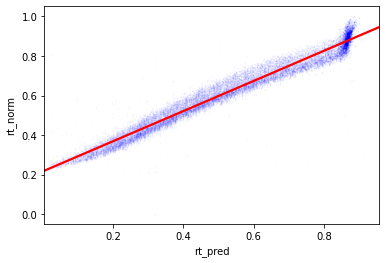

,R_square,R,slope,intercept,n_sample
0,0.957,0.978264,0.7611,0.2172,38027.0


In [ ]:
psm_df = get_psm_df_by_gradient(mq_reader.psm_df, gradient=11)
for _, df_group in psm_df.groupby('raw_name'):
    psm_df.loc[df_group.index,'rt_norm'] = df_group.rt_norm / df_group.rt_norm.max()

predict_df = rt_model.predict(psm_df)

evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

## Transfer learning on short gradient

In [ ]:
import numpy as np
import pandas as pd
n_train = 4000

from peptdeep.model.rt import uniform_sampling
train_df, test_df = uniform_sampling(psm_df, target='rt_norm', n_train=n_train, return_test_df=True)
rt_model.train(train_df, epoch=20, verbose=True, verbose_each_epoch=False)

[Training] Epoch=1, Mean Loss=0.04449705730247147
[Training] Epoch=2, Mean Loss=0.032233188476632625
[Training] Epoch=3, Mean Loss=0.026625069515670046
[Training] Epoch=4, Mean Loss=0.026529881966245526
[Training] Epoch=5, Mean Loss=0.023169235435917097
[Training] Epoch=6, Mean Loss=0.018989483510856244
[Training] Epoch=7, Mean Loss=0.01938353111857877
[Training] Epoch=8, Mean Loss=0.020884855705149034
[Training] Epoch=9, Mean Loss=0.01995359709048096
[Training] Epoch=10, Mean Loss=0.01858697270097978
[Training] Epoch=11, Mean Loss=0.014855733716531712
[Training] Epoch=12, Mean Loss=0.016413939431967103
[Training] Epoch=13, Mean Loss=0.017110895831137896
[Training] Epoch=14, Mean Loss=0.017406584147144768
[Training] Epoch=15, Mean Loss=0.014141354983782066
[Training] Epoch=16, Mean Loss=0.015030781984986627
[Training] Epoch=17, Mean Loss=0.014211423818350714
[Training] Epoch=18, Mean Loss=0.01557089451371747
[Training] Epoch=19, Mean Loss=0.015433185268193483
[Training] Epoch=20, Mean 

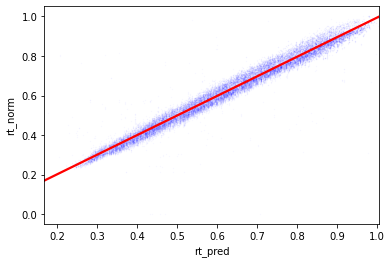

,R_square,R,slope,intercept,n_sample
0,0.971,0.985393,0.9889,0.0049,34822.0


In [ ]:
predict_df = rt_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

<AxesSubplot:ylabel='Frequency'>

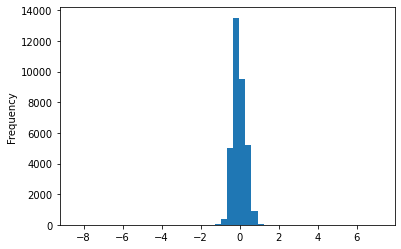

In [ ]:
(predict_df.rt.max()*(predict_df.rt_norm-predict_df.rt_pred)).plot.hist(bins=50)